## Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import lasagne
from lasagne.layers import *
import theano
import theano.tensor as T
from agentnet.agent import Recurrence

from collections import OrderedDict

In [7]:
BATCH_SIZE,SEQ_LENGTH = 1,10

## Data Generator

In [3]:
def generator(X,batch_size,seq_length):
    
    while True:
        start = np.random.randint(0,len(X)-seq_length-1,(batch_size))

        batches= start[:,None] + np.arange(seq_length+1)[None,:]

        batch= X[batches]
        yield batch[:,:-1],batch[:,1:]

### Test Data

In [4]:
X = np.load("./radar_test5k.npy")
X = np.log(1+X)

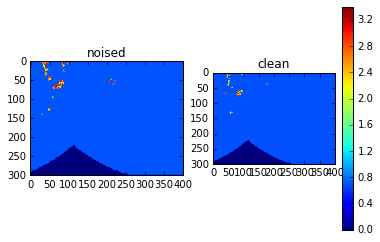

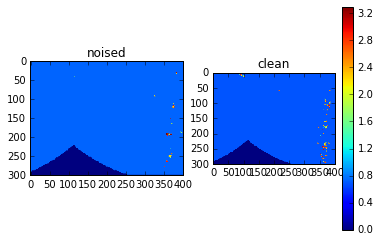

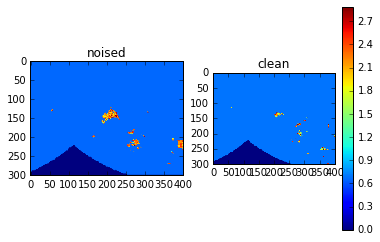

In [8]:
gen = generator(X,BATCH_SIZE,SEQ_LENGTH)
for i in range(3):
    x,y = gen.next()
    plt.subplot(121)
    plt.imshow(x[0,0])
    plt.title('X')
    plt.subplot(122)
    plt.imshow(y[0,0])
    plt.title('Xnext(Y)')
    plt.colorbar()
    plt.show()


### Goal: 
predict clean data obtaining only noised ones.

### Network Structure

In [9]:
# shape of input image
inp_shape = X.shape[1:]

X_seq_inp = T.tensor4()
# add "1" dimension (3rd)
X_seq = X_seq_inp[:,:,None,:,:]

X_seq_layer = InputLayer([None,None,1,inp_shape[0], inp_shape[1]],input_var=X_seq,name='seq_of_inputs')

In [10]:
generator_init_var = T.tensor4()
# None - ?
generator_init = InputLayer([None,1,inp_shape[0], inp_shape[1]],generator_init_var,name='generator_init')

In [11]:
# batch size to know input size for gen part
gen_batch_size = theano.shared(1)

#### Recurrent part of NN

In [13]:
# TODO: Understand the result of Recurrence:
# Now the output is a convolution with pads
# Training: parameters of convolutions -> result - prediction

def build_recurrence(X_seq_layer,n_hidden = 8,generator_init=generator_init):
    '''
    ---------------------------------------------------------------------------------------------
    Input:
            X_seq_layer    -- sequence of input images, lasagne layer with size 5!:
                            [batch size?, nmb of input images, 1, [input_image.shape()]]
            n_hidden       -- number of hidden neurons per pixel
            generator_init -- initial input in gererative part of RNN, lasagne layer with size 4:
                            [batch size?, 1, [input_image.shape()]]
                                
    ----------------------------------------------------------------------------------------------
    Output:
            crnn_rec -- Recurrence
            crnn_gen -- Generative Recurrence
            crnn_out -- Conv2Dlayer  (X_new)
            crnn_new -- Nonlinearity (H_new)

    -----------------------------------------------------------------------------------------------
    '''
    
    
    Xi_inp = InputLayer([None,1,inp_shape[0], inp_shape[1]],name='x_i')
    
    H_prev = InputLayer([None,n_hidden,inp_shape[0], inp_shape[1]],name='hidden prev')


    # Convolution with Xi_inp: [None,1,input_shape] --> [None,n_hidden,input_shape]
    crnn_from_inp = Conv2DLayer(Xi_inp,
                                num_filters=n_hidden,
                                filter_size=[5,5],#arbitrary
                                b = None, #only apply bias once in from_hid
                                nonlinearity=None,
                                pad='same',
                                name='conv rnn input')
    
    # Convolution with H_prev: [None,n_hidden,input_shape] --> [None,n_hidden,input_shape]
    crnn_from_hid = Conv2DLayer(H_prev,
                                num_filters=n_hidden,
                                filter_size=[3,3], #arbitrary
                                nonlinearity=None,
                                pad='same',
                                name ='conv rnn hid to hid')


    crnn_sum = ElemwiseSumLayer([crnn_from_hid,crnn_from_inp])



    crnn_new = NonlinearityLayer(crnn_sum, lasagne.nonlinearities.elu)
    
    # Convolution with crnn_new.out: [None,n_hidden,input_shape] --> [None,1,input_shape]
    crnn_out = Conv2DLayer(crnn_new,
                           num_filters=1,
                           filter_size=[3,3],#arbitrary
                            nonlinearity=None, #!!! if precip.rate >0, use ReLU or similar
                            pad='same',
                            name ='conv rnn to prediction',)


    # Out of crnn_new to H_prev
    mem_dict = {crnn_new: H_prev}
    
    # Part of AgentNet: 
    # take imgs iteratively from X_seq_layer to Xi_inp n_steps times 
    # crnn_rec.outputs[0] -- tracked_outputs
    # assert (X_seq_layer.shape[2] >= n_steps)
    crnn_rec = Recurrence(input_sequences={Xi_inp:X_seq_layer},
                          tracked_outputs = crnn_out,
                         state_variables = mem_dict,
                         n_steps = SEQ_LENGTH)
    
    #-----------------------------------------------------------
    # generative part 
    
    mem_dict_generator = OrderedDict([(crnn_new, H_prev),
                                      (crnn_out,Xi_inp)])
    
    #first state
    state_init_gen = {crnn_out:generator_init}
    
    crnn_gen = Recurrence(tracked_outputs = crnn_out,
                        state_variables = mem_dict_generator,
                        n_steps = SEQ_LENGTH,
                        batch_size=gen_batch_size,
                        state_init = state_init_gen)
    #-------------------------------------------------------------
    
    return crnn_rec,crnn_gen, crnn_out,crnn_new


In [14]:
rec_layer,rec_gen_layer,X_new_layer,H_new_layer = build_recurrence(X_seq_layer=X_seq_layer)

/usr/local/lib/python2.7/site-packages/agentnet-0.9.0-py2.7.egg/agentnet/agent/recurrence.py:197: UserWarning: You are giving Recurrence an input sequence of undefined length (None).
Make sure it is always above 10(n_steps) you specified for recurrence
  "Make sure it is always above {}(n_steps) you specified for recurrence".format(n_steps))


In [15]:
# get layers generated hidden_output and prediction  
states, outputs = rec_layer.get_sequence_layers()

In [16]:
# sequence of hidden crnn states
hidden_state_seq_layer = states[H_new_layer]

# sequence of predictions
pred_y_seq_layer = outputs[0]

In [17]:
# [none, n_steps, 1,input_shape[0], input_sahpe[1]]
pred_y_seq = lasagne.layers.get_output(pred_y_seq_layer)

# get rid of "1": [none,n_steps,input_shape[0], input_sahpe[1]]
pred_y_seq=pred_y_seq[:,:,0,]

### weights

In [18]:
weights = lasagne.layers.get_all_params(pred_y_seq_layer,trainable=True)
weights

[conv rnn hid to hid.W,
 conv rnn hid to hid.b,
 conv rnn input.W,
 conv rnn to prediction.W,
 conv rnn to prediction.b]

In [19]:
total_weights = int(T.sum([T.prod(w.shape) for w in weights]).eval())
print "Total weights:", total_weights

Total weights: 857


### loss

In [20]:
# [none,n_steps,32,32]
Y_seq = T.tensor4()

mse = lasagne.objectives.squared_error(Y_seq,pred_y_seq).mean()

In [21]:
# #regularizer 
# from lasagne.regularization import regularize_network_params, l2
# reg_l2 = regularize_network_params(pred_y_seq_layer,l2)*10**-5
# loss = mse + reg_l2

In [22]:
updates = lasagne.updates.adamax(mse,weights)

In [ ]:
train_func = theano.function([X_seq_inp,Y_seq], mse, updates=updates)
#evaluation_fun = theano.function([sequences_batch],[loss,mse,reg_l2])

### Train

In [ ]:
losses = []
N_EPOCHS = 1000
for epoch in range(N_EPOCHS):
    
    x_batch, y_batch = gen.next()
    losses.append( train_func(x_batch,y_batch))
    if epoch%100==0:
        print "epoch:",epoch

plt.plot(losses)

pic
epoch: 0
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
epoch: 100
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic
pic


In [ ]:
pred_1_step = theano.function([X_seq_inp],pred_y_seq)

In [ ]:
for i, img in enumerate(pred_1_step(x_batch)[0]):
    plt.subplot(121)
    plt.imshow(img,vmin=-3,vmax=3)
    plt.title('prediction')
    
    plt.subplot(122)
    plt.imshow(y_batch[0][i],vmin=-3,vmax=3)
    plt.title('ground truth')
    plt.show()

In [93]:
gen_states,gen_outputs = rec_generator.get_sequence_layers()

gen_seq = lasagne.layers.get_output(gen_outputs[0])

generate = theano.function([generator_init_var], gen_seq)

In [94]:
x_batch.shape

(1, 15, 32, 32)

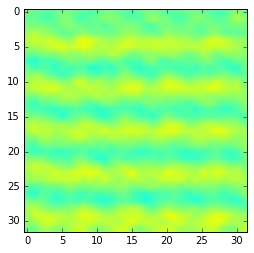

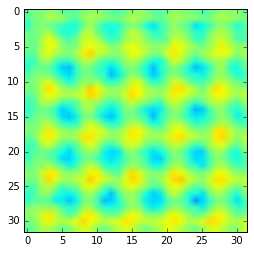

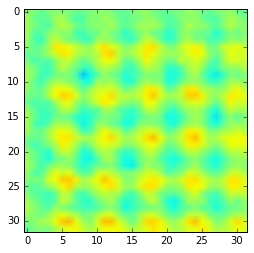

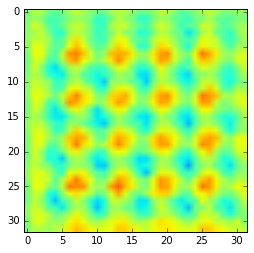

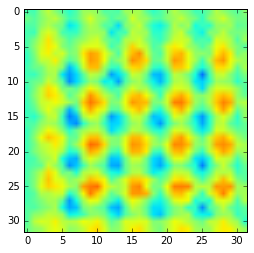

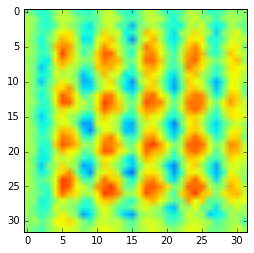

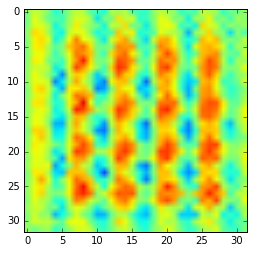

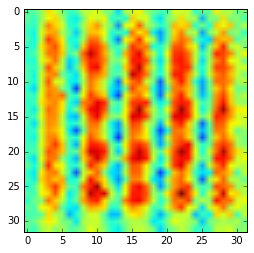

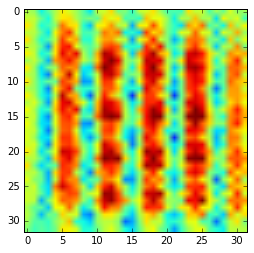

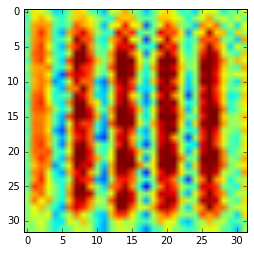

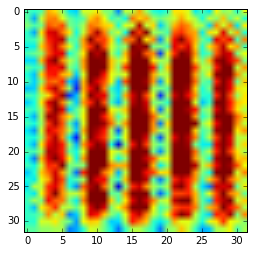

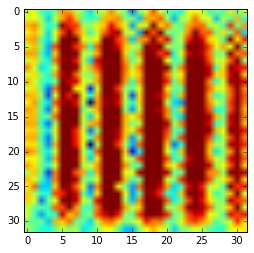

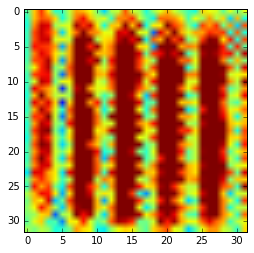

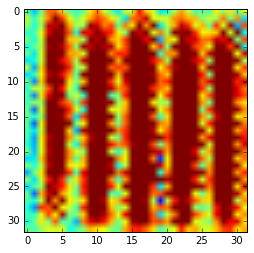

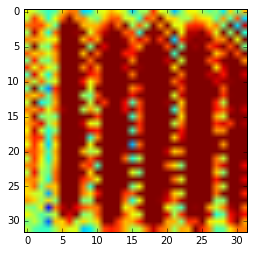

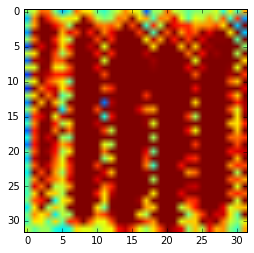

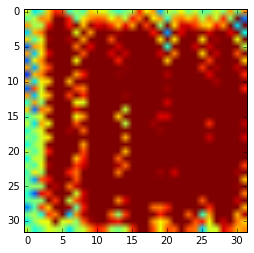

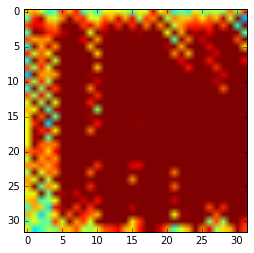

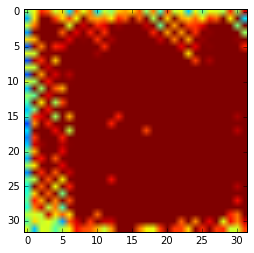

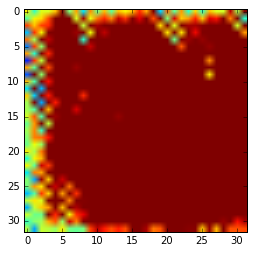

In [95]:
init= x_batch[:,0,None,]
for img in generate(init)[0,:,0]:
    plt.imshow(img,vmin=-3,vmax=3)
    plt.show()